# Resultados de entrenamiento sobre datasets CT con anotaciones de tumor
- Tabla con datasets
- Pipeline: [nnUNet](https://github.com/MIC-DKFZ/nnUNet)
- Resultados sobre fold 0

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def get_df_from_msd(path_to_summary, dataset):
    """Return a pandas dataframe from the 'summary.json' file for MSD datasets."""
    with open(path_to_summary, 'r') as fp:
        summary = json.load(fp)
    if dataset == "task03":
        results_task03_liver = [
            {
                "dataset": "task03-liver",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "liver",
                **item["metrics"]["1"]
            }
            for item in summary["metric_per_case"]
        ]
        results_task03_tumor = [
            {
                "dataset": "task03-liver",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "tumor",
                **item["metrics"]["2"]
            }
            for item in summary["metric_per_case"]
        ]
        results_task03_liver = pd.DataFrame(results_task03_liver)
        results_task03_tumor = pd.DataFrame(results_task03_tumor)
        results = pd.concat([results_task03_liver, results_task03_tumor])
        results.reset_index(inplace=True, drop=True)
    elif dataset == "task06":
        results = [
            {
                "dataset": "task06-lung",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "tumor",
                **item["metrics"]["1"]
            }
            for item in summary["metric_per_case"]
        ]
        results = pd.DataFrame(results)
    elif dataset == "task07":
        results_task07_pancreas = [
            {
                "dataset": "task07-pancreas",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "pancreas",
                **item["metrics"]["1"]
            }
            for item in summary["metric_per_case"]
        ]
        results_task07_tumor = [
            {
                "dataset": "task07-pancreas",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "tumor",
                **item["metrics"]["2"]
            }
            for item in summary["metric_per_case"]
        ]
        results_task07_pancreas = pd.DataFrame(results_task07_pancreas)
        results_task07_tumor = pd.DataFrame(results_task07_tumor)
        results = pd.concat([results_task07_pancreas, results_task07_tumor])
        results.reset_index(inplace=True, drop=True)
    elif dataset == "task10":
        results = [
            {
                "dataset": "task10-colon",
                "patient": Path(item["prediction_file"]).name,
                "foreground": "tumor",
                **item["metrics"]["1"]
            }
            for item in summary["metric_per_case"]
        ]
        results = pd.DataFrame(results)
    else:
        raise ValueError("Invalid 'dataset' argument.")
    return results

In [3]:
path_to_task03 = Path('resources/summary_task03_liver_CTAbdomen_fold0.json')
path_to_task06 = Path('resources/summary_task06_lung_CTAbdomen_fold0.json')
path_to_task07 = Path('resources/summary_task07_pancreas_CTAbdomen_fold0.json')
path_to_task10 = Path('resources/summary_task10_colon_CTAbdomen_fold0.json')
datasets = {
    "task03-liver": {"alias": "task03", "path": path_to_task03},
    "task06-lung": {"alias": "task06", "path": path_to_task06},
    "task07-pancreas": {"alias": "task07", "path": path_to_task07},
    "task10-liver": {"alias": "task10", "path": path_to_task10}
}

In [4]:
for key, results in datasets.items():    
    result_df = get_df_from_msd(results['path'], results['alias'])
    datasets[key].update({"results_df": pd.DataFrame(result_df)})

In [5]:
all_results_df = pd.concat([dataset["results_df"] for dataset in datasets.values()])
all_results_df.groupby(['dataset', 'foreground']).describe()["Dice"]

count      mean       std       min       25%  \
dataset         foreground                                                  
task03-liver    liver        27.0  0.962181  0.025716  0.852342  0.955462   
                tumor        24.0  0.699306  0.233793  0.000000  0.606344   
task06-lung     tumor        13.0  0.572838  0.294374  0.000000  0.546691   
task07-pancreas pancreas     57.0  0.818407  0.087306  0.485073  0.785109   
                tumor        57.0  0.531282  0.317521  0.000000  0.230413   
task10-colon    tumor        26.0  0.463003  0.388465  0.000000  0.000000   

                                 50%       75%       max  
dataset         foreground                                
task03-liver    liver       0.967504  0.977817  0.984148  
                tumor       0.803453  0.842351  0.903044  
task06-lung     tumor       0.642158  0.772339  0.879937  
task07-pancreas pancreas    0.852767  0.874944  0.932668  
                tumor       0.689817  0.805233  0.914180  
task10-colon    tumor       0.686992  0.812842  0.906797

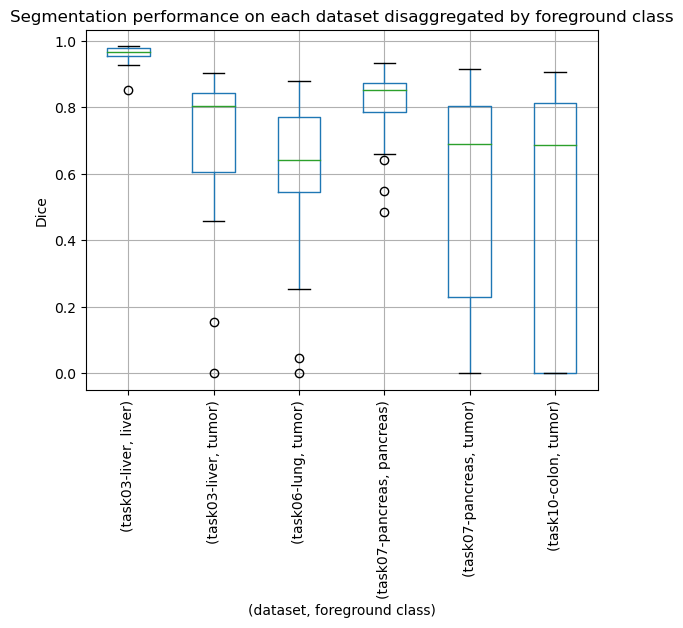

In [6]:
all_results_df.boxplot(column="Dice", by=["dataset", "foreground"])
plt.suptitle('')
plt.title('Segmentation performance on each dataset disaggregated by foreground class')
plt.xticks(rotation=90)
plt.xlabel('(dataset, foreground class)')
plt.ylabel('Dice')
plt.show()

In [7]:
grouped = all_results_df.groupby(['dataset', 'foreground'])
all_results_df_sorted = grouped.apply(lambda group: group.sort_values(by='Dice', ascending=False))
#all_results_df_sorted.to_csv("summary_all.csv", index=False)